In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 5)

In [2]:
# Tiền xử lý dữ liệu
## Xử lý dữ liệu thiếu
transfers_data = pd.read_csv('../../Output/Output_I/player_transfers.csv')
players_data = pd.read_csv('../../Output/Output_I/players_stats.csv')
players_data['transfer_value'] = transfers_data['transfer_value']
def convert_transfer_value(value):
    if value == 'N/a':
        return np.nan
    value = value.replace('€', '')
    if 'M' in value:
        return float(value.replace('M', '')) * 1_000_000
    elif 'K' in value:
        return float(value.replace('K', '')) * 1_000
    else:
        return float(value)
players_data['transfer_value'] = players_data['transfer_value'].apply(convert_transfer_value)
median_transfer_value = players_data['transfer_value'].median()
players_data['transfer_value'] = players_data['transfer_value'].fillna(median_transfer_value)
features = players_data.columns.tolist()
null_features = []
for feature in features:
    if players_data[feature].dtype == object:
        if players_data[feature].str.contains("N/a").any():
            null_features.append(feature)
    else:
        if players_data[feature].isnull().any():
            null_features.append(feature)
print(f"Number of features: {len(features)}")
print(f"Features with 'N/a' values: {len(null_features)}")
print(f"null_features: {null_features}")

for feature in null_features:
    null_count = players_data[feature].str.contains("N/a").sum()
    total_count = len(players_data)
    null_percentage = (null_count / total_count) * 100
    feature_type = players_data[feature].dtype
    print(f"Feature: {feature}, Null Percentage: {null_percentage:.2f}%, Type: {feature_type}")
for feature in null_features:
    if players_data[feature].dtype == object:
        null_count = players_data[feature].str.contains("N/a").sum()
    total_count = len(players_data)
    null_percentage = (null_count / total_count) * 100
    if null_percentage > 90:
        players_data = players_data.drop(columns=[feature])
    else:
        mode_value = players_data[players_data[feature] != "N/a"][feature].mode()[0]
        players_data[feature] = players_data[feature].replace("N/a", mode_value)
        
print(f"shape {players_data.shape}")


## Chuyển đổi sang kiểu dữ liệu số
for feature in players_data.columns:
    try:
        players_data[feature] = pd.to_numeric(players_data[feature])
        print(f"Converted feature: {feature} to numeric")
    except ValueError:
        pass
numeric_features = players_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = players_data.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")
for feature in categorical_features:
    unique_values = players_data[feature].unique()
    print(f"Feature: {feature}, Unique values: {unique_values}")

drop_columns = ['Name', 'Team', 'Nation']
players_data = players_data.drop(columns=drop_columns)
goal_scoring_map = {
    # 0 - Thủ môn
    'GK': 0,
    
    # 1 - Hậu vệ
    'DF': 1,
    'DFFW': 1,
    
    # 2 - Tiền vệ phòng ngự
    'DFMF': 2,
    'MFDF': 2,
    
    # 3 - Tiền vệ trung tâm
    'MF': 3,
    
    # 4 - Tiền vệ công 
    'MFFW': 4,
    'FWMF': 4,
    'FWDF': 4, 
    
    # 5 - Tiền đạo cắm
    'FW': 5
}
players_data['Position'] = players_data['Position'].map(goal_scoring_map)

## Phân tích dữ liệu số 
numeric_summary = players_data[players_data.columns].describe().T
print("Numeric Features Summary:")
print(numeric_summary)

## Chuẩn hóa dữ liệu
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
players_data_scaled = scaler.fit_transform(players_data[players_data.columns])
players_data_scaled = pd.DataFrame(players_data_scaled, columns=players_data.columns)

## Mô tả dữ liệu sau tiền xử lý
numeric_summary_scaled = players_data_scaled.describe()
print("Numeric Features Summary after Scaling:")
print(numeric_summary_scaled)


Number of features: 76
Features with 'N/a' values: 12
null_features: ['Nation', 'GA90', 'Save_Pct', 'CS_Pct', 'PK_Save_Pct', 'SoT_Pct', 'Goals_Per_Shot', 'Avg_Shot_Distance', 'Long_Pass_Pct', 'Take_Ons_Success_Pct', 'Take_Ons_Tackled_Pct', 'Aerials_Won_Pct']
Feature: Nation, Null Percentage: 0.20%, Type: object
Feature: GA90, Null Percentage: 91.83%, Type: object
Feature: Save_Pct, Null Percentage: 91.83%, Type: object
Feature: CS_Pct, Null Percentage: 91.83%, Type: object
Feature: PK_Save_Pct, Null Percentage: 94.22%, Type: object
Feature: SoT_Pct, Null Percentage: 10.96%, Type: object
Feature: Goals_Per_Shot, Null Percentage: 10.96%, Type: object
Feature: Avg_Shot_Distance, Null Percentage: 10.96%, Type: object
Feature: Long_Pass_Pct, Null Percentage: 0.80%, Type: object
Feature: Take_Ons_Success_Pct, Null Percentage: 7.97%, Type: object
Feature: Take_Ons_Tackled_Pct, Null Percentage: 7.97%, Type: object
Feature: Aerials_Won_Pct, Null Percentage: 1.39%, Type: object
shape (502, 72)
C

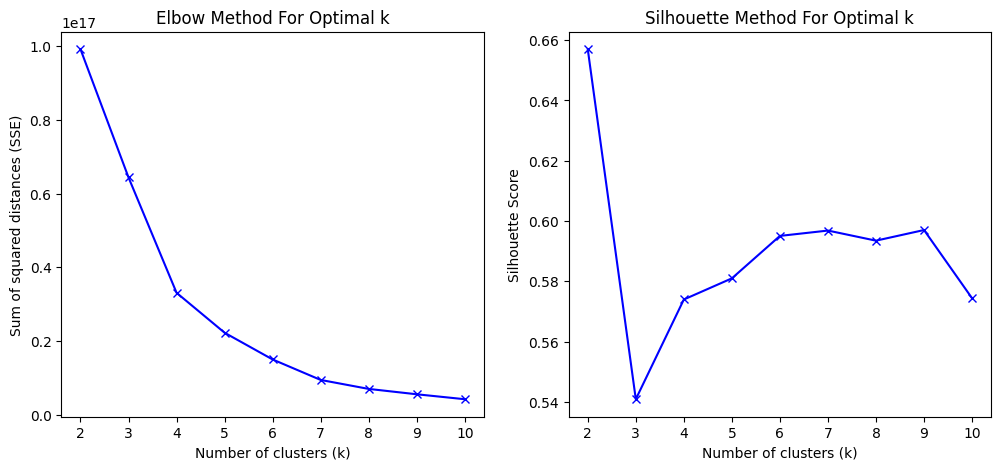

In [3]:
#  Áp dụng thuật toán k-means để phân cụm cầu thủ, vẽ biểu đồ Elbow, Silhouette
## Áp dụng dữ liệu trước khi chuẩn hóa
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
sse = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(players_data)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(players_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, sse,'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.title('Elbow Method For Optimal k')
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.savefig('../../Output/Output_IV/before_scaled_kmeans_clustering_elbow_silhouette.png')
plt.show()


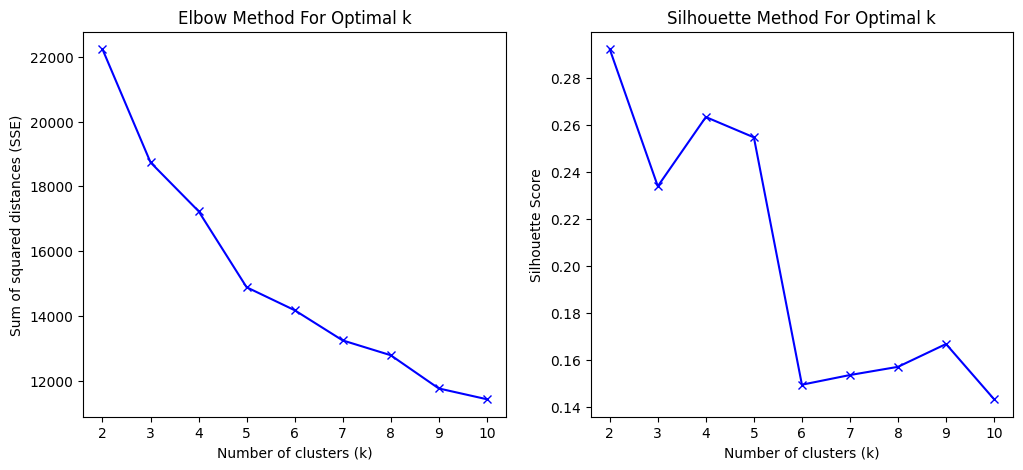

In [4]:
## Áp dụng dữ liệu sau khi chuẩn hóa
sse_scaled = []
silhouette_scores_scaled = []
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(players_data_scaled)
    sse_scaled.append(kmeans.inertia_)
    silhouette_avg_scaled = silhouette_score(players_data_scaled, kmeans.labels_)
    silhouette_scores_scaled.append(silhouette_avg_scaled)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, sse_scaled, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.title('Elbow Method For Optimal k')
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores_scaled, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.savefig('../../Output/Output_IV/after_scaled_kmeans_clustering_elbow_silhouette.png')
plt.show()



# Nhận xét chọn K theo phương pháp Elbow

Trước khi Scale:
Biểu đồ này có vẻ có "khuỷu tay" khá rõ. Giảm mạnh từ k=2 đến k=3, và từ k=4 đến k=5.
Tại k=5, đường cong bắt đầu thoai thoải rõ rệt. Có thể kết luận k=5 là một lựa chọn hợp lý

Sau khi Scale:
Biểu đồ đường cong giảm khá mượt và đều, có một điểm khuỷu tay (elbow) nằm ở k = 5. đây là lúc độ dốc bắt đầu giảm chậm lại một chút. 


# Nhận xét chọn K theo Silhouette
k=2 là đỉnh cao nhất

Top 5 features with highest variance: ['Touches_Def_Pen', 'Carries_Into_Penalty_Area', 'Offsides', 'xG', 'Take_Ons_Tackled_Pct']


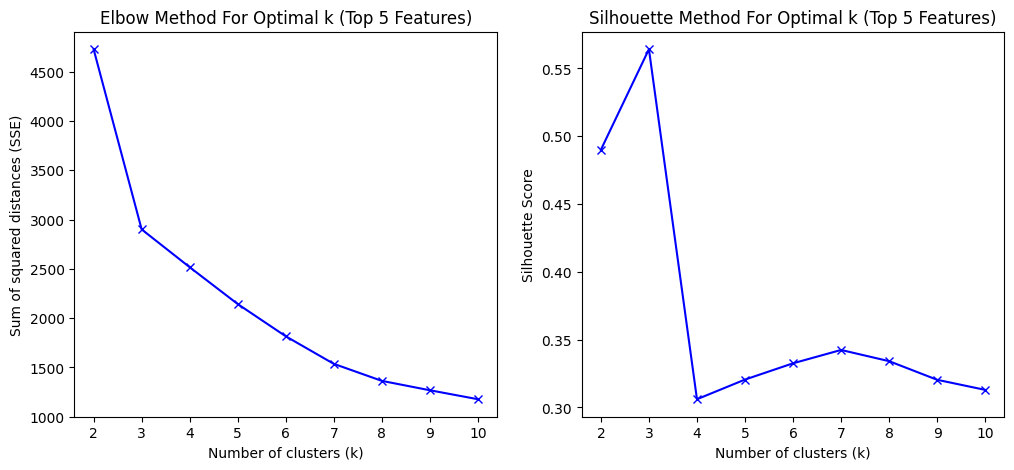

In [5]:
## Lựa chọn features để phân cụm sau khi chuẩn hóa (5 cột có phương sai cao nhất)
from sklearn.cluster import KMeans
variances = players_data_scaled.var().sort_values(ascending=False)
top_5_features = variances.head(5).index.tolist()
print(f"Top 5 features with highest variance: {top_5_features}")
players_data_scaled_top5 = players_data_scaled[top_5_features]
kmeans_top5 = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_top5.fit(players_data_scaled_top5)
sse_top5 = []
silhouette_scores_top5 = []
K_top5 = range(2, 11)
for k in K_top5:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(players_data_scaled_top5)
    sse_top5.append(kmeans.inertia_)
    silhouette_avg_top5 = silhouette_score(players_data_scaled_top5, kmeans.labels_)
    silhouette_scores_top5.append(silhouette_avg_top5)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_top5, sse_top5, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.title('Elbow Method For Optimal k (Top 5 Features)')
plt.subplot(1, 2, 2)
plt.plot(K_top5, silhouette_scores_top5, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k (Top 5 Features)')
plt.savefig('../../Output/Output_IV/top5_features_kmeans_clustering_elbow_silhouette.png')
plt.show()



Một điểm Silhouette Score > 0.5 thường được coi là dấu hiệu của cấu trúc phân cụm tốt, có ý nghĩa, các cụm được tách biệt rõ ràng. Biểu đồ có một đỉnh cao, rõ ràng tại k=3. Elbow Khuỷu tay rõ ràng tại k=3.

Nhận xét:
Dựa trên hai biểu đồ này, đây là một kết quả phân cụm rất thành công và đáng tin cậy. Cả hai phương pháp đều cho ra một kết quả đồng nhất.
Lựa chọn tối ưu k = 3.

In [6]:
# Lưu kết quả phân cụm vào các file CSV
src_transfers_data = pd.read_csv('../../Output/Output_I/player_transfers.csv')
src_players_data = pd.read_csv('../../Output/Output_I/players_stats.csv')
src_players_data['transfer_value'] = src_transfers_data['transfer_value']
kmeans_top5 = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_top5.fit(players_data_scaled_top5)
src_players_data['Cluster'] = kmeans_top5.labels_
for cluster_num in range(3):
    cluster_data = src_players_data[src_players_data['Cluster'] == cluster_num]
    cluster_data.to_csv(f'../../Output/Output_IV/cluster_{cluster_num + 1}.csv', index=False)

In [7]:
import pandas as pd

src_players_data['Take_Ons_Tackled_Pct'] = pd.to_numeric(
    src_players_data['Take_Ons_Tackled_Pct'], errors='coerce'
)

median_value = src_players_data['Take_Ons_Tackled_Pct'].median()
src_players_data['Take_Ons_Tackled_Pct'] = src_players_data['Take_Ons_Tackled_Pct'].fillna(median_value)
for cluster_num in range(3):
    print(f"\n==================== Cluster {cluster_num} ====================")
    cluster_data = src_players_data[src_players_data['Cluster'] == cluster_num]
    print(cluster_data[top_5_features].describe())


==================== Cluster 0 ====================
       Touches_Def_Pen  Carries_Into_Penalty_Area    Offsides          xG  \
count       424.000000                 424.000000  424.000000  424.000000   
mean         74.716981                   4.792453    1.471698    1.353774   
std          92.265293                   6.868528    2.006880    1.579833   
min           0.000000                   0.000000    0.000000    0.000000   
25%          12.000000                   0.000000    0.000000    0.200000   
50%          37.000000                   2.000000    1.000000    0.800000   
75%          97.500000                   7.000000    2.000000    1.825000   
max         464.000000                  46.000000   10.000000    9.900000   

       Take_Ons_Tackled_Pct  
count            424.000000  
mean              43.708726  
std               20.773063  
min                0.000000  
25%               33.300000  
50%               44.150000  
75%               50.000000  
max          

### Đặc điểm chi tiết 3 Cụm

* **Cụm 0: Hậu vệ & Tiền vệ phòng ngự (n=424)**
    * Đây là nhóm **đa số**.
    * **Đặc điểm:** Các chỉ số ở mức trung bình, có thiên hướng phòng ngự (mean **`Touches_Def_Pen`** 74.7) nhưng đóng góp tấn công rất thấp (mean **`xG`** 1.35, mean **`Carries_Into_Penalty_Area`** 4.79).
    * **Vai trò:** Có thể là nhóm cầu thủ phòng ngự hoặc chơi ở giữa sân.

* **Cụm 1: Thủ môn (n=20)**
    * Đây là nhóm **nhỏ nhất và chuyên biệt nhất**.
    * **Đặc điểm:** Chỉ số phòng ngự **cực kỳ cao** (mean **`Touches_Def_Pen`** 912.4) và tất cả các chỉ số tấn công khác đều **gần như bằng 0**.
    * **Vai trò:** Nhóm này được xác định có thể là các Thủ môn.

* **Cụm 2: Cầu thủ Tấn công & Tiền đạo (n=58)**
    * Đây là nhóm **chuyên tấn công**.
    * **Đặc điểm:** Hoàn toàn trái ngược với 2 cụm kia. Chỉ số phòng ngự rất thấp (mean **`Touches_Def_Pen`** 25.7) nhưng các chỉ số tấn công **cao vượt trội** (mean **`Carries_Into_Penalty_Area`** 40.68, mean **`xG`** 9.05, mean **`Offsides`** 11.12).
    * **Vai trò:** Có thể là nhóm cầu thủ dứt điểm chính của đội.

For n_clusters = 3, the average silhouette_score is : 0.5642022588756238


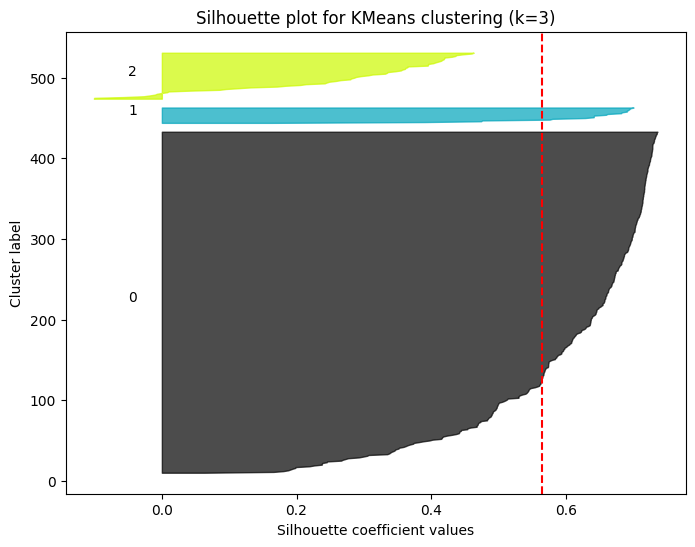

Number of points with negative silhouette values: 8


In [8]:
# Vẽ biểu đồ silhouette với k = 3
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
k = 3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(players_data_scaled_top5)
silhouette_avg = silhouette_score(players_data_scaled_top5, cluster_labels)
print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg}")
sample_silhouette_values = silhouette_samples(players_data_scaled_top5, cluster_labels)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)
y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title("Silhouette plot for KMeans clustering (k=3)")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")
plt.savefig('../../Output/Output_IV/silhouette_plot_k3.png')
plt.show()

# Liệt kê các điểm có giá trị silhouette âm
negative_silhouette_points = players_data_scaled_top5[sample_silhouette_values < 0]
print(f"Number of points with negative silhouette values: {negative_silhouette_points.shape[0]}")

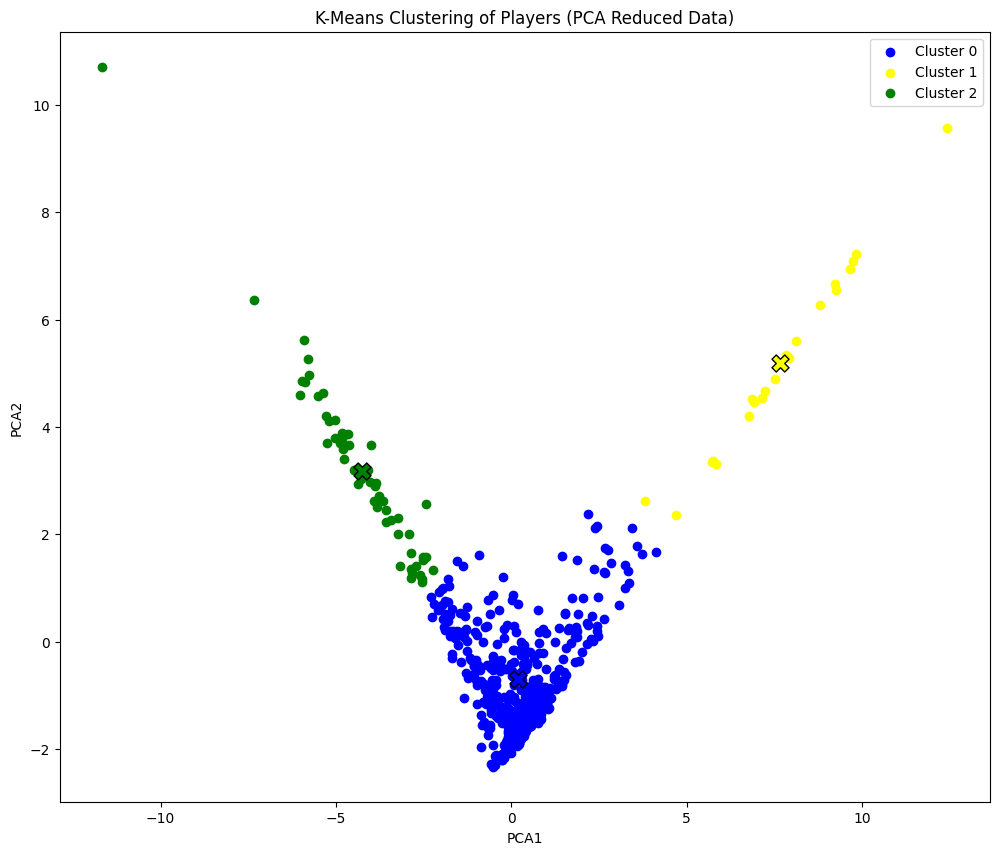

In [9]:

# scatter plot phân cụm các điểm dữ liệu trên mặt 2D.
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, kmeans_plusplus
k = 3

pca_2d = PCA(n_components=2)
players_data_pca_2d = pca_2d.fit_transform(players_data_scaled_top5)
centers, indices = kmeans_plusplus(players_data_pca_2d, n_clusters=k, random_state=42)
kmeans_pca_2d = KMeans(n_clusters=k, init=centers, n_init=1, random_state=42)
kmeans_pca_2d.fit(players_data_pca_2d)
players_data_pca_2d_df = pd.DataFrame(players_data_pca_2d, columns=['PCA1', 'PCA2'])
players_data_pca_2d_df['Cluster'] = kmeans_pca_2d.labels_
plt.figure(figsize=(12, 10))
players_data_centers = kmeans_pca_2d.cluster_centers_
colors = ['blue', 'yellow', 'green'] 
for cluster in range(k):
    cluster_data = players_data_pca_2d_df[players_data_pca_2d_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], 
                cluster_data['PCA2'], 
                c=colors[cluster],  
                label=f'Cluster {cluster}')
    
    plt.scatter(players_data_centers[cluster, 0],  
                players_data_centers[cluster, 1],  
                s=150,                 
                c=colors[cluster],     
                marker='X', 
                edgecolor='black')      


plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('K-Means Clustering of Players (PCA Reduced Data)')
plt.legend()
plt.savefig('../../Output/Output_IV/kmeans_clustering_pca_2d.png')
plt.show()

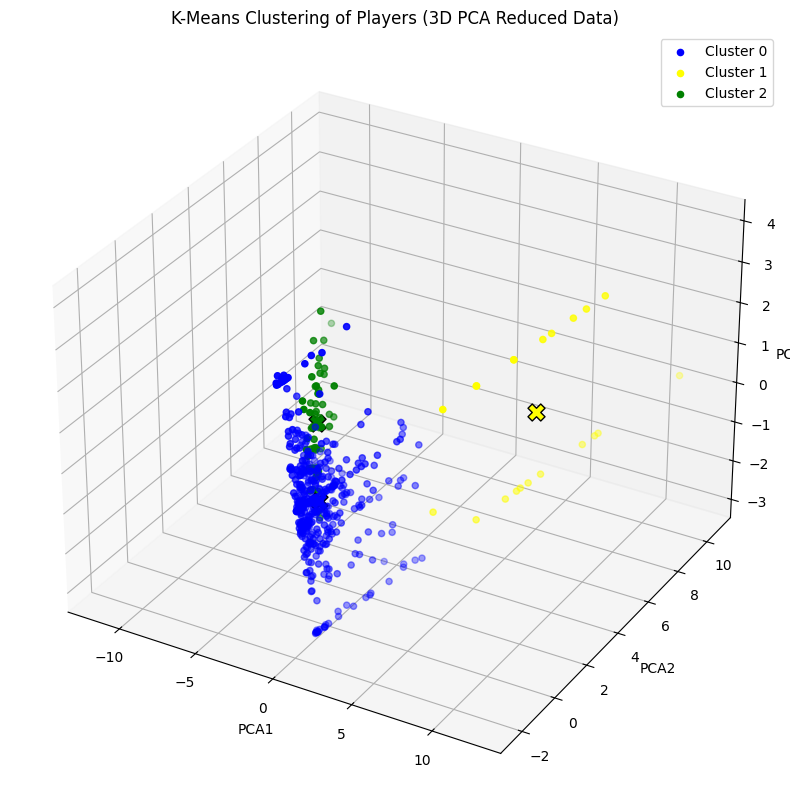

In [10]:
# scatter plot phân cụm các điểm dữ liệu trên khối 3D.
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, kmeans_plusplus
k = 3

pca_3d = PCA(n_components=3)
players_data_pca_3d = pca_3d.fit_transform(players_data_scaled_top5)
centers_3d, indices_3d = kmeans_plusplus(players_data_pca_3d, n_clusters=k, random_state=42)
kmeans_pca_3d = KMeans(n_clusters=k, init=centers_3d, n_init=1,random_state=42)
kmeans_pca_3d.fit(players_data_pca_3d)
players_data_pca_3d_df = pd.DataFrame(players_data_pca_3d, columns=['PCA1', 'PCA2', 'PCA3'])
players_data_pca_3d_df['Cluster'] = kmeans_pca_3d.labels_
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
players_data_centers_3d = kmeans_pca_3d.cluster_centers_
colors = ['blue', 'yellow', 'green'] 
for cluster in range(k):
    cluster_data = players_data_pca_3d_df[players_data_pca_3d_df['Cluster'] == cluster]
    ax.scatter(cluster_data['PCA1'], 
               cluster_data['PCA2'], 
               cluster_data['PCA3'], 
               c=colors[cluster],  
               label=f'Cluster {cluster}')
    
    ax.scatter(players_data_centers_3d[cluster, 0],  
               players_data_centers_3d[cluster, 1],  
               players_data_centers_3d[cluster, 2],  
               s=150,                 
               c=colors[cluster],     
               marker='X', 
               edgecolor='black')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('K-Means Clustering of Players (3D PCA Reduced Data)')
ax.legend()
plt.savefig('../../Output/Output_IV/kmeans_clustering_pca_3d.png')
plt.show()
